In [1]:
import gpmultipy, scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gpmultipy import dataset
from gpmultipy.model import Model
from gpmultipy.prior import Prior
from gpmultipy.kernel import RBF, White
from gpmultipy.freeze import Freezer
from gpmultipy.sampler.slice import Slice
from gpmultipy.kernel import Product, Linear

In [3]:
%matplotlib inline

In [12]:
ds = dataset.DataSet('data/')
x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',Bio='F',effects=['Well'])
y = np.log2(y)
y = y-y[0,:]
y = (y-y.mean())/y.std()

dm = np.ones((y.shape[1],1))

In [16]:
def wellPosition(number):
    number = int(number)
    if number > 100:
        return wellPosition(number%100)
    if number == 0:
        return 9,9
    return [(number-1) % 10, (number-1)/10]

position = np.array(map(wellPosition,labels[0]))
zip(labels[0],position)

[(211, array([0, 1])),
 (212, array([1, 1])),
 (213, array([2, 1])),
 (214, array([3, 1])),
 (215, array([4, 1])),
 (216, array([5, 1])),
 (217, array([6, 1])),
 (218, array([7, 1])),
 (219, array([8, 1])),
 (220, array([9, 1]))]

In [ ]:
select = np.all(position != 0,1)


In [31]:
yKernel = White(1,.1)
k1 = RBF(1,1,1)

# yKernel = White(1,1)
# k1 = RBF(1,1,1)

p = y.shape[1]
dm = np.ones((1,p))

prior = Prior(x,k1,range(dm.shape[0]))

model = Model(x,y,dm)

In [32]:
ySigmaSlice = Slice('ySigma',
                    lambda x: model.dataLikelihood(yKernel,sigma=x),
                    #lambda x: scipy.stats.uniform(1e-6,1e0).logpdf(x),
                    #lambda x: scipy.stats.lognorm(1,loc=1e-2,scale=1e-1).logpdf(x),
                    lambda x: scipy.stats.lognorm(1,scale=1e-0).logpdf(x),
                    #debug_lognorm,
                    .2,5,logspace=True)

kSigmaSlice = Slice('kSigma',
                    lambda x: prior.loglikelihood(model.beta,sigma=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    #debug_unif,
                    .2,5,logspace=True)

kLengthscaleSlice = Slice('kLengthscale',
                    lambda x: prior.loglikelihood(model.beta,lengthscale=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

samples = []
freeze = Freezer(yKernel=yKernel,k1=k1,model=model)

In [33]:
thin = 10
burnin = 0
nsample = 1000

for i in range(nsample):
    prior.sample(model,yKernel)

    k1.sigma = kSigmaSlice.sample(k1.sigma)
    yKernel.sigma = ySigmaSlice.sample(yKernel.sigma)
    k1.lengthscale = kLengthscaleSlice.sample(k1.lengthscale)

    if i % thin == 0 and i > burnin:
        print model.dataLikelihood(yKernel),yKernel.sigma, k1.sigma, k1.lengthscale
        samples.append(freeze.freeze())

284.980392755 0.0390877861357 9.49837382073 0.306107640134
284.399847541 0.0425651083987 3.32263219305 0.207054782148
287.698494991 0.0403369899899 1.70170449554 0.171827372491
286.355943994 0.038498303391 1.3924356128 0.146650527902
288.767969367 0.0362025719545 0.718648799247 0.155214306777
282.102962678 0.0413088452064 1.72152633235 0.231323071437
277.587364439 0.0348122566484 1.49589147786 0.181508400475
283.43411554 0.0376193693013 0.713268186442 0.208633501343
285.755006726 0.0375810892481 0.972426097266 0.226979776359
283.775205538 0.0416975321179 0.599053509805 0.176151766754
281.615134546 0.0431559304786 0.289617339874 0.209472498392
286.435321813 0.0417073844782 0.650235928527 0.215639248476
288.543775004 0.0390643825991 1.16758439983 0.187531471961
282.194819559 0.0394297495002 0.406364420642 0.163996638984
279.221966335 0.0432345743911 1.05873475979 0.214196684817
285.613312482 0.0374588856277 1.4739210799 0.238290860456
285.191751744 0.0380297137789 6.98595761184 0.2277103

(array([  1.,   1.,   3.,  10.,  22.,  20.,  29.,  11.,   1.,   1.]),
 array([-0.94290745, -0.90002929, -0.85715112, -0.81427296, -0.7713948 ,
        -0.72851664, -0.68563848, -0.64276032, -0.59988215, -0.55700399,
        -0.51412583]),
 <a list of 10 Patch objects>)

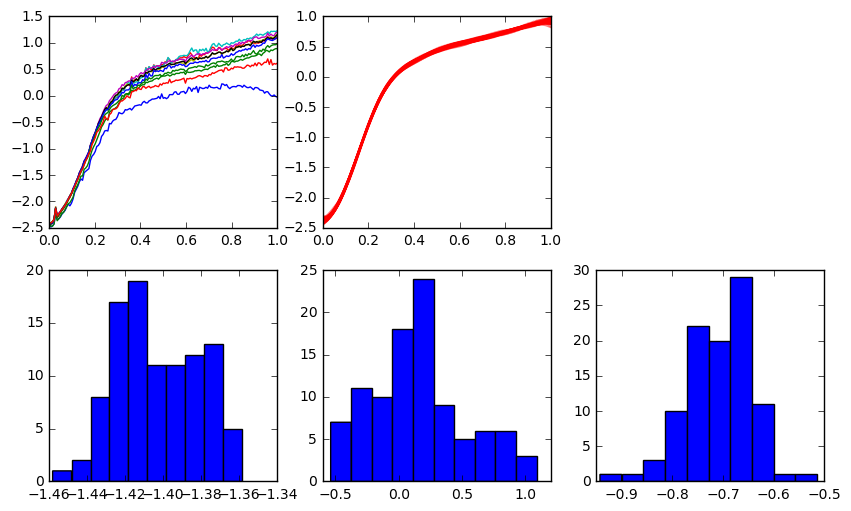

In [34]:
plt.figure(figsize=(10,6))
plt.subplot(231)
plt.plot(x,y)

plt.subplot(232)
plt.plot(x,np.array([s['model']['beta'][:,0] for s in samples]).T,c='r',alpha=.5)

plt.subplot(234)
plt.hist(np.log10([s['yKernel']['sigma'] for s in samples]))

plt.subplot(235)
plt.hist(np.log10([s['k1']['sigma'] for s in samples]))

plt.subplot(236)
plt.hist(np.log10([s['k1']['lengthscale'] for s in samples]))

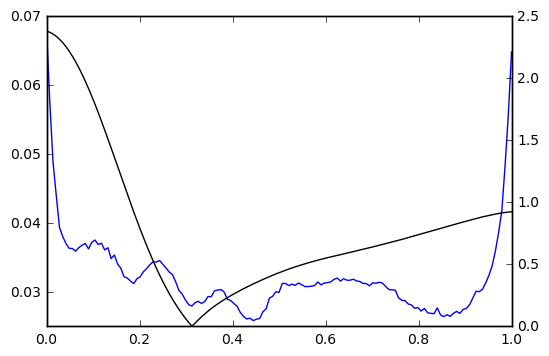

In [40]:
mu = np.array([s['model']['beta'][:,0] for s in samples]).T

plt.plot(x,mu.std(1)*2);

plt.twinx()
plt.plot(x,abs(mu.mean(1)),c='k');

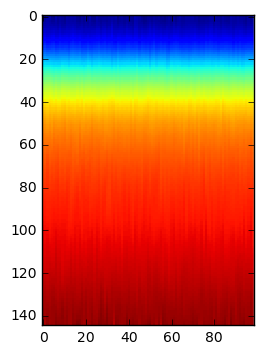

In [37]:
plt.imshow(mu,interpolation='none')

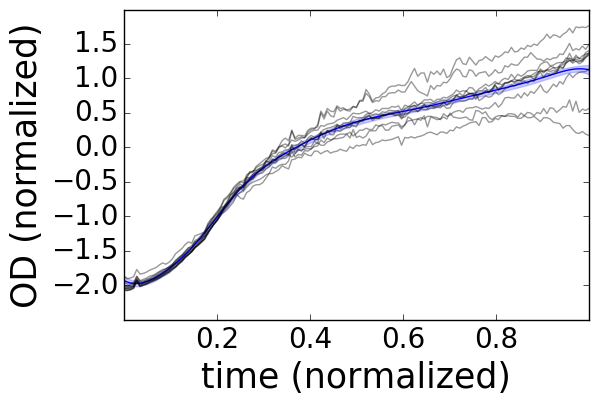

In [34]:
plt.figure(figsize=(6,4))

# gpfanova.plot.plotFunctionSamples(m_noReplicate.functionSamples(0).values,x=x[:,0])
plt.plot(x[:,0],y,c='k',alpha=.4)

plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("OD (normalized)",fontsize=25)
plt.xticks(np.arange(.2,1,.2),fontsize=20)
plt.yticks(np.arange(-2,2,.5),fontsize=20)

plt.savefig("figures/ura3-pq-replicate/model-noReplicate-singleReplicate.pdf",bbox_inches='tight',dpi=300)

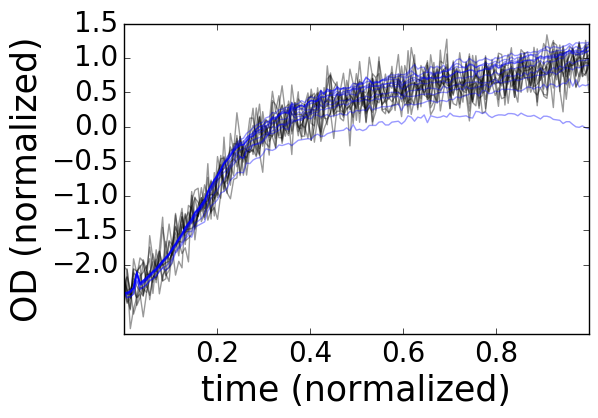

In [38]:
plt.figure(figsize=(6,4))

mu = samples[-1]['model']['beta'][:,0]
cov = yKernel.K(x)
ysample = mu + scipy.stats.multivariate_normal.rvs(np.zeros(x.shape[0]),cov,size=model.r)

plt.plot(x[:,0],ysample.T,c='k',alpha=.4); 
plt.plot(x[:,0],y,c='b',alpha=.4); 
# plt.plot(x[:,0],fsample,c='r',lw=3);

plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("OD (normalized)",fontsize=25)
plt.xticks(np.arange(.2,1,.2),fontsize=20)
plt.yticks(np.arange(-2,2,.5),fontsize=20)

plt.savefig("figures/model-noEffect-generative.pdf",bbox_inches='tight',dpi=300)